<a href="https://colab.research.google.com/github/Varun-tej-reddy/Plant_Desease_Detection/blob/main/ViT_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Desease Detection Model Using MobileViT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile, os, shutil

# Extract the dataset from Drive
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()

print("✅ Dataset extracted successfully!")


Mounted at /content/drive
✅ Dataset extracted successfully!


In [ ]:
import os, shutil

def rename_folders(base_dir):
    for crop in os.listdir(base_dir):
        crop_path = os.path.join(base_dir, crop)
        if not os.path.isdir(crop_path):
            continue

        for condition in os.listdir(crop_path):
            old_path = os.path.join(crop_path, condition)
            if not os.path.isdir(old_path):
                continue

            new_folder_name = f"{crop}_{condition}"
            new_path = os.path.join(base_dir, new_folder_name)

            if os.path.exists(new_path):
                for file in os.listdir(old_path):
                    shutil.move(os.path.join(old_path, file), new_path)
                os.rmdir(old_path)
            else:
                shutil.move(old_path, new_path)

        if not os.listdir(crop_path):
            os.rmdir(crop_path)

base_dir = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset"
rename_folders(base_dir)
print("✅ Dataset folders renamed successfully!")


✅ Dataset folders renamed successfully!


In [ ]:
import os
import shutil
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile   # 👈 add this
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 👇 add this line here
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
IMAGE_SIZE = 224
PATCH_SIZE = 16

In [ ]:
# Verify Images Function
def verify_images(directory):
    broken_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except Exception as e:
                print(f" Corrupted image: {file_path} | Error: {e}")
                broken_images.append(file_path)
    return broken_images

In [ ]:
# Train/Validation Split (fixed to stay inside dataset folder)
def split_dataset(base_dir, val_ratio=0.15):
    val_base_dir = os.path.join(base_dir, "Validation")

    classes = os.listdir(base_dir)
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        if cls == "Validation":  # skip if Validation already exists
            continue

        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(images) == 0:
            print(f"⚠ No images found in {cls_path}")
            continue

        train_imgs, val_imgs = train_test_split(images, test_size=val_ratio, random_state=42)

        # Create validation dir for this class
        val_dir = os.path.join(val_base_dir, cls)
        os.makedirs(val_dir, exist_ok=True)

        # Move validation images
        for img in val_imgs:
            shutil.move(os.path.join(cls_path, img), os.path.join(val_dir, img))

        print(f"✅ Moved {len(val_imgs)} images to {val_dir}")

In [ ]:
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

In [ ]:
   # Load Dataset
def load_datasets(train_path, val_path):
    train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_path, transform=val_transforms)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    return train_loader, val_loader, train_dataset.classes

In [ ]:
# Convert Image Batch to ViT Patches
def image_to_patches(img_batch, patch_size):
    B, C, H, W = img_batch.shape  # Batch Size, Channels, Height, Width
    patches = img_batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous().view(B, -1, C * patch_size * patch_size)
    return patches  # Shape: (Batch, Num_Patches, Flattened Patch Size)

In [ ]:
# Display Sample Images with Patches
def imshow_batch(loader, classes):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    def unnormalize(img):
        std_tensor = torch.tensor(std_vals).view(3, 1, 1)
        mean_tensor = torch.tensor(mean_vals).view(3, 1, 1)
        img = img * std_tensor + mean_tensor  # Reverse normalization
        return img.clamp(0, 1)  # Clip values between 0-1

    fig, axes = plt.subplots(1, 8, figsize=(20, 3))
    for i in range(8):
        img = unnormalize(images[i]).permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()
# Convert to Patches for ViT
    patches = image_to_patches(images, PATCH_SIZE)
    print(f"Patches Shape: {patches.shape}")  # (Batch, Num_Patches, Flattened Patch Size)

# Run Pipeline
dataset_path = "/content/Dataset for Crop Pest and Disease Detection"
train_path = os.path.join(dataset_path, "Train")
val_path = os.path.join(dataset_path, "Test")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm # Import timm here
from torch.utils.data import random_split # Import random_split
import os # Import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalization values (standard for ImageNet)
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]

# Image preprocessing (using transforms defined earlier for consistency)
# Assuming train_transforms are suitable for both train and test for initial loading
IMAGE_SIZE = 224 # Define IMAGE_SIZE here
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std_vals) # Using mean_vals and std_vals defined earlier
])

# Dataset paths
dataset_root = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset"

# Check if the dataset directory exists
if not os.path.exists(dataset_root):
    print(f"Error: Dataset directory not found at {dataset_root}")
else:
    # Load full dataset to split
    full_dataset = datasets.ImageFolder(dataset_root, transform=transform)

    class_names = full_dataset.classes
    print("Class Labels:", class_names)

    num_classes = len(full_dataset.classes)

    # Load pretrained MobileViT from timm
    model = timm.create_model("mobilevit_xxs", pretrained=True, num_classes=num_classes)
    model.to(device)

    # Dataloaders (Splitting the full dataset into train and test)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, val_size]) # Using test_dataset for consistency with the rest of the code

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    print("✅ Model and DataLoaders initialized successfully!")

    # Train and evaluate the model
    # Removed the calls to train_model and evaluate_model from here

Class Labels: ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf miner', 'Cashew_red rust', 'Cassava_bacterial blight', 'Cassava_brown spot', 'Cassava_green mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf beetle', 'Maize_leaf blight', 'Maize_leaf spot', 'Maize_streak virus', 'Tomato_healthy', 'Tomato_leaf blight', 'Tomato_leaf curl', 'Tomato_septoria leaf spot', 'Tomato_verticulium wilt']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

✅ Model and DataLoaders initialized successfully!


In [ ]:
# Clean dataset from corrupt images
corrupt_files = verify_images(dataset_path)
if corrupt_files:
    print(f"⚠ Found {len(corrupt_files)} corrupt images. Removing them...")
    for f in corrupt_files:
        try:
            os.remove(f)
            print(f"Removed: {f}")
        except Exception as e:
            print(f"Error removing {f}: {e}")
else:
    print("✅ No corrupt images found!")

# Rebuild datasets and loaders after cleanup
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transforms)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

print("✅ Dataloaders rebuilt successfully")

 Corrupted image: /content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_leaf spot/leaf spot425_.jpg | Error: cannot identify image file '/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_leaf spot/leaf spot425_.jpg'
 Corrupted image: /content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_leaf spot/leaf spot187_.jpg | Error: cannot identify image file '/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_leaf spot/leaf spot187_.jpg'
 Corrupted image: /content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_leaf spot/leaf spot958_.jpg | Error: cannot identify image file '/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_leaf spot/leaf spot958_.jpg'
 Corrupted image: /content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize_leaf spot/leaf spot799_.jpg | Error: cannot identify image file '/content/Datas

Verifying images...
All images verified successfully.
Classes: ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf miner', 'Cashew_red rust', 'Cassava_bacterial blight', 'Cassava_brown spot', 'Cassava_green mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf beetle', 'Maize_leaf blight', 'Maize_leaf spot', 'Maize_streak virus', 'Tomato_healthy', 'Tomato_leaf blight', 'Tomato_leaf curl', 'Tomato_septoria leaf spot', 'Tomato_verticulium wilt']


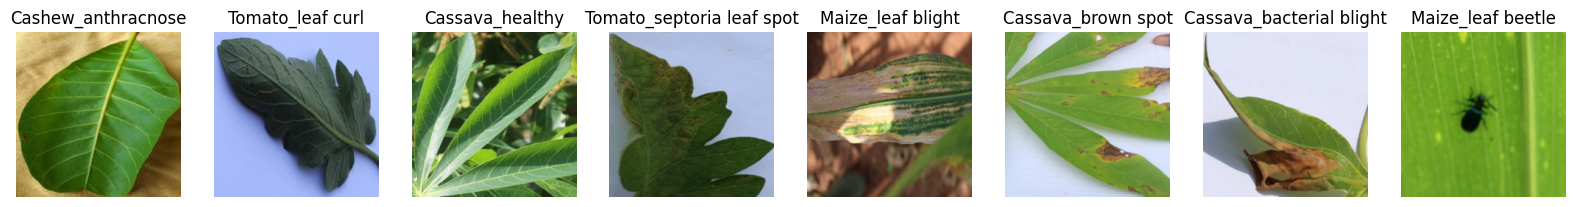

Patches Shape: torch.Size([8, 196, 768])


In [ ]:
# Define paths
dataset_path = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset"

# Verify images before processing
print("Verifying images...")
broken_images = verify_images(dataset_path)
if broken_images:
    print(f"Found {len(broken_images)} broken images. Consider removing them.")
    # Optionally add code here to remove or quarantine broken_images
else:
    print("All images verified successfully.")

# Train/Validation split handled automatically by torch.utils.data.random_split
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transforms)

# 80/20 split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

class_names = full_dataset.classes
print("Classes:", class_names)

# Show a sample batch
imshow_batch(train_loader, class_names)

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Normalization values (standard for ImageNet)
mean_vals = [0.485, 0.456, 0.406]
std_vals  = [0.229, 0.224, 0.225]

IMAGE_SIZE = 224  # You can lower to 160×160 for mobile optimization

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std_vals)
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std_vals)
])

# Function to load dataset
def load_datasets(train_path, val_path, batch_size=8):
    train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
    val_dataset   = datasets.ImageFolder(val_path,   transform=val_transforms)
    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
    val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, train_dataset.classes


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🔥 Using device:", device)

dataset_root = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset"

# Load full dataset to split
full_dataset = datasets.ImageFolder(dataset_root, transform=train_transforms)
class_names  = full_dataset.classes
num_classes  = len(class_names)

print("Classes:", class_names)
print("Number of Classes:", num_classes)


🔥 Using device: cuda
Classes: ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf miner', 'Cashew_red rust', 'Cassava_bacterial blight', 'Cassava_brown spot', 'Cassava_green mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf beetle', 'Maize_leaf blight', 'Maize_leaf spot', 'Maize_streak virus', 'Tomato_healthy', 'Tomato_leaf blight', 'Tomato_leaf curl', 'Tomato_septoria leaf spot', 'Tomato_verticulium wilt']
Number of Classes: 22


In [ ]:
!pip uninstall -y timm
!pip install timm==1.0.3

import torch
from timm import create_model
from torchvision import datasets, transforms
import os

# Define paths
dataset_root = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset"

# Image preprocessing (using transforms defined earlier for consistency)
# Assuming train_transforms are suitable for both train and test for initial loading
IMAGE_SIZE = 224 # Define IMAGE_SIZE here
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std_vals) # Using mean_vals and std_vals defined earlier
])

# Load full dataset to get the number of classes
full_dataset = datasets.ImageFolder(dataset_root, transform=transform)
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")

# choose model variant
model_name = 'mobilevit_xxs' # Corrected model name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create model
model = create_model(model_name, pretrained=True, num_classes=num_classes)
model.to(device)

print("✅ MobileViT model loaded successfully!")
import timm
print(timm.__version__)
print(timm.list_models('mobilevit*'))

Found existing installation: timm 1.0.22
Uninstalling timm-1.0.22:
  Successfully uninstalled timm-1.0.22
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 49.8 MB/s eta 0:00:00


Number of classes: 22
✅ MobileViT model loaded successfully!
1.0.22
['mobilevit_s', 'mobilevit_xs', 'mobilevit_xxs', 'mobilevitv2_050', 'mobilevitv2_075', 'mobilevitv2_100', 'mobilevitv2_125', 'mobilevitv2_150', 'mobilevitv2_175', 'mobilevitv2_200']


In [ ]:
def train_model(model, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.4f}")


In [ ]:
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define paths
dataset_root = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset"

# Image preprocessing (using transforms defined earlier for consistency)
# Assuming train_transforms are suitable for both train and test for initial loading
IMAGE_SIZE = 224 # Define IMAGE_SIZE here
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std_vals) # Using mean_vals and std_vals defined earlier
])

# Load full dataset to get the number of classes
full_dataset = datasets.ImageFolder(dataset_root, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    acc = 100 * correct / total
    print(f"✅ Validation Accuracy: {acc:.2f}%")

# Removed the calls to train_model and evaluate_model from here

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_model(model, train_loader, epochs=30)
evaluate_model(model, val_loader)

Epoch [1/30], Loss: 0.2512
Epoch [2/30], Loss: 0.2251
Epoch [3/30], Loss: 0.2118
Epoch [4/30], Loss: 0.1939
Epoch [5/30], Loss: 0.1800
Epoch [6/30], Loss: 0.1722
Epoch [7/30], Loss: 0.1600
Epoch [8/30], Loss: 0.1496
Epoch [9/30], Loss: 0.1373
Epoch [10/30], Loss: 0.1276
Epoch [11/30], Loss: 0.1220
Epoch [12/30], Loss: 0.1129
Epoch [13/30], Loss: 0.1078
Epoch [14/30], Loss: 0.1057
Epoch [15/30], Loss: 0.1043
Epoch [16/30], Loss: 0.0996
Epoch [17/30], Loss: 0.0967
Epoch [18/30], Loss: 0.0858
Epoch [19/30], Loss: 0.0848
Epoch [20/30], Loss: 0.0867
Epoch [21/30], Loss: 0.0823
Epoch [22/30], Loss: 0.0757
Epoch [23/30], Loss: 0.0805
Epoch [24/30], Loss: 0.0763
Epoch [25/30], Loss: 0.0712
Epoch [26/30], Loss: 0.0727
Epoch [27/30], Loss: 0.0670
Epoch [28/30], Loss: 0.0648
Epoch [29/30], Loss: 0.0650
Epoch [30/30], Loss: 0.0647
✅ Validation Accuracy: 88.54%


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import requests # Import requests
import io # Import io
import torch
from torchvision import datasets, transforms
import os

# Define dataset_root, IMAGE_SIZE, mean_vals, std_vals, and train_transforms
dataset_root = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset"
IMAGE_SIZE = 224
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

# Load full dataset to get class names
full_dataset = datasets.ImageFolder(dataset_root, transform=train_transforms)
class_names = full_dataset.classes

def predict_leaf(image_path):
    if image_path.startswith("http://") or image_path.startswith("https://"):
        # Download image from URL
        try:
            response = requests.get(image_path)
            response.raise_for_status() # Raise an exception for bad status codes
            img = Image.open(io.BytesIO(response.content)).convert("RGB")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading image from {image_path}: {e}")
            return None, None # Return None for both prediction and image on error
        except Exception as e:
            print(f"Error opening downloaded image from {image_path}: {e}")
            return None, None
    else:
        # Open image from local path
        try:
            img = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            print(f"Error: Local file not found at {image_path}")
            return None, None
        except Exception as e:
            print(f"Error opening local image from {image_path}: {e}")
            return None, None


    img_tensor = train_transforms(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)

    pred_class = class_names[pred.item()]

    # Split crop and condition
    if "_" in pred_class:
        crop, condition = pred_class.split("_", 1)
    else:
        crop, condition = pred_class, "Unknown"

    if condition.lower() == "healthy":
        return f"{crop} leaf is Healthy ✅", img
    else:
        return f"{crop} leaf is Not Healthy ❌ (Disease: {condition})", img

Enter leaf image paths (comma separated): /content/cassava-mosaic-disease-manioc-1561129470.jpg,/content/images (1).jpeg,/content/images.jpeg,/content/leaf-spot-of-maize-maize-1575459018.jpg

Image 1: Cassava leaf is Not Healthy ❌ (Disease: mosaic)


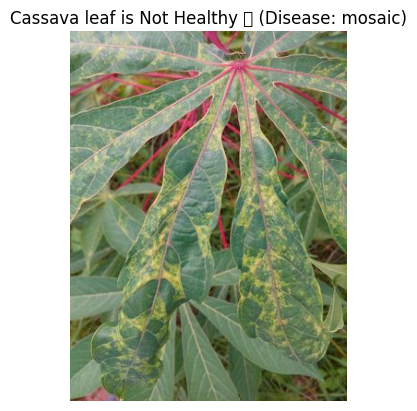


Image 2: Cashew leaf is Not Healthy ❌ (Disease: leaf miner)


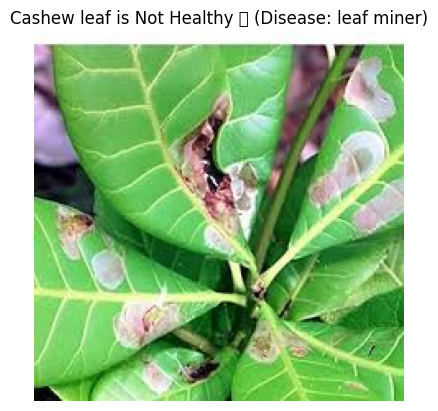


Image 3: Cassava leaf is Not Healthy ❌ (Disease: mosaic)


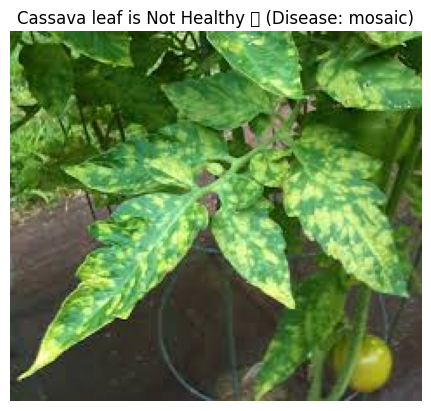


Image 4: Maize leaf is Not Healthy ❌ (Disease: leaf spot)


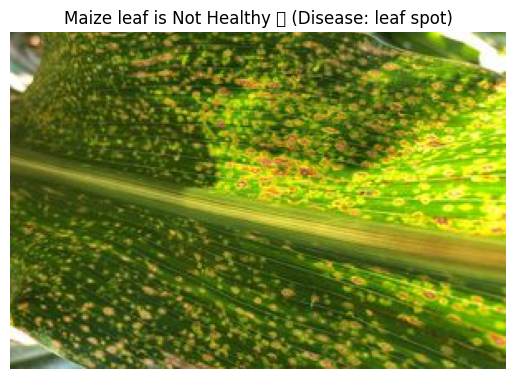

In [ ]:
def main():
    image_paths = input("Enter leaf image paths (comma separated): ")
    if not image_paths:
        print("Please provide valid image paths.")
        return

    for idx, path in enumerate(image_paths.split(",")):
        prediction, img = predict_leaf(path.strip())
        print(f"\nImage {idx+1}: {prediction}")

        plt.imshow(img)
        plt.title(prediction)
        plt.axis("off")
        plt.show()

if __name__ == "__main__":
    main()
